In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
import learnHeat as lh
from pygsp import plotting
from scipy.linalg import expm
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

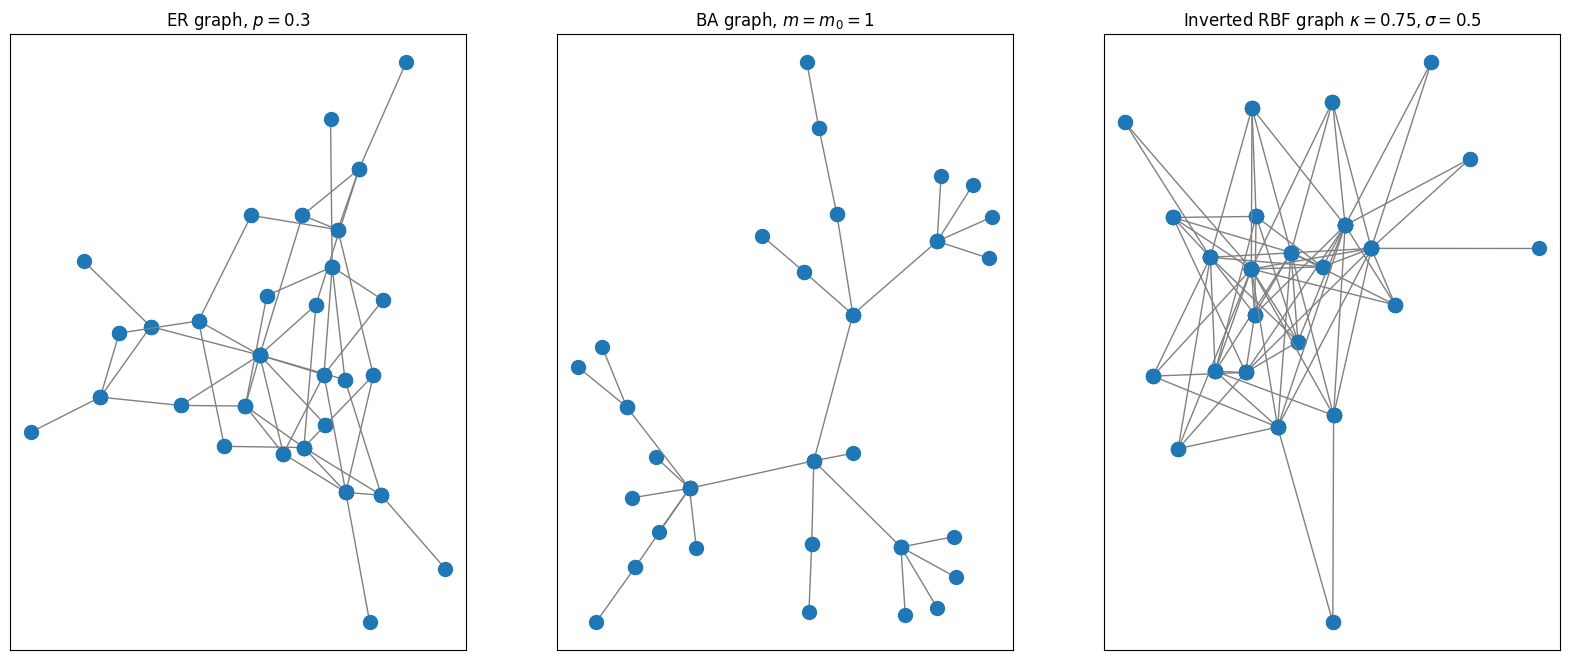

In [20]:
N = 30
G1 = pg.graphs.ErdosRenyi(N)
G2 = pg.graphs.BarabasiAlbert(N)
titles=[r"ER graph, $p=0.3$",r"BA graph, $m=m_0=1$",r"Inverted RBF graph $\kappa=0.75,\sigma=0.5$"]
L = lh.heat_graph_RBF(N)
W = lh.laplacian_to_adjacency(L)
G3 = pg.graphs.Graph(W)
G = [G1,G2,G3]
fig, axs = plt.subplots(1,3,figsize=(20,8))
for i in range(3):
    G[i].set_coordinates()
    pg.plotting.plot_graph(G[i],ax=axs[i])
    axs[i].set_title(titles[i])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

Figure 3:
Let's just take a path graph and learn it and threshold it.

In [21]:
N = 21
path_graph = pg.graphs.Path(N)
path_L = path_graph.L.todense()
path_L = N*path_L/np.trace(path_L)
delta = np.zeros(N)
delta[10] = 1
path_X = expm(-10*path_L)@delta
path_X = path_X.reshape(N,1)
delta2 = expm(-5*path_L)@delta

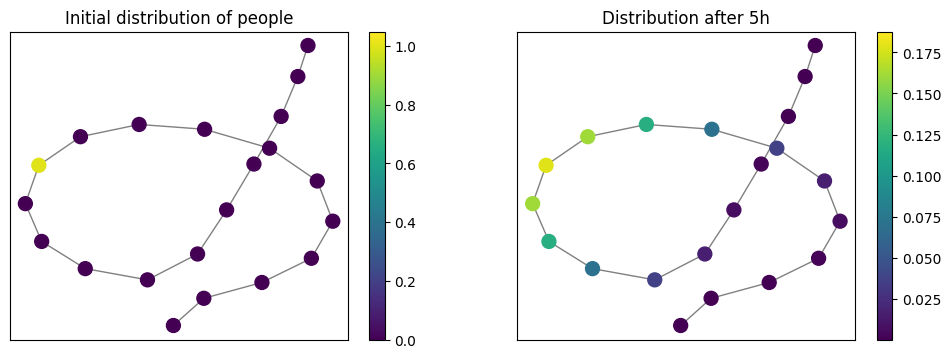

In [22]:
path_graph.set_coordinates()
fig, ax = plt.subplots(1,2,figsize=(12,4))
plotting.plot_signal(path_graph,delta,ax=ax[0])
plotting.plot_signal(path_graph,delta2,ax=ax[1])
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[0].set_title("Initial distribution of people")
ax[1].set_title("Distribution after 5h")
plt.show()

In [23]:
path_res = lh.learn_heat(X=path_X,tau0=[1],alpha=0.01,beta=0.1,max_iter=50)

20.0


Text(0.5, 1.0, '20 most weighted edges')

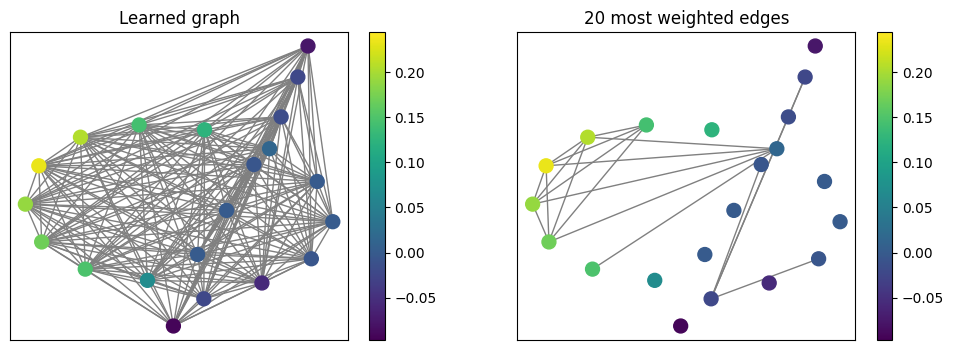

In [25]:
path_learned = path_res["L"]
path_learned[abs(path_learned)<0.001] = 0
path_signal = path_res["H"]
path_W = lh.laplacian_to_adjacency(path_learned)
# path_W[path_W<0.001] = 0
path_G_learned = pg.graphs.Graph(path_W)
path_G_learned.set_coordinates(path_graph.coords)
A = np.sort(path_learned.flatten())
thresh = lh.heat_threshold(path_learned,-A[39])
print(lh.heat_numedges(thresh))
path_W2 = lh.laplacian_to_adjacency(thresh)
path_G_2 = pg.graphs.Graph(path_W2)
path_G_2.set_coordinates(path_graph.coords)
fig, ax = plt.subplots(1,2,figsize=(12,4))
plotting.plot_signal(path_G_learned,path_signal,ax=ax[0])
#filter path graph
plotting.plot_signal(path_G_2,path_signal,ax=ax[1])
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[0].set_title("Learned graph")
ax[1].set_title("20 most weighted edges")

In [62]:
path_W2[path_W2!=0]

array([0.27458, 0.48195, 0.1915 , 0.30285, 0.34462, 0.1902 , 0.42892,
       0.30404, 0.24036, 0.22522, 0.30285, 0.30404, 0.37432, 0.46452,
       0.23681, 0.2196 , 0.76426, 0.76426, 0.54545, 0.74607, 0.54545,
       0.37432, 0.2196 , 0.74607, 0.46452, 0.21949, 0.23681, 0.20008,
       0.22734, 0.27458, 0.34462, 0.24036, 0.21949, 0.20008, 0.48195,
       0.1915 , 0.42892, 0.22522, 0.22734])

In [56]:
path_learned


In [9]:
tau = path_res["tau"]

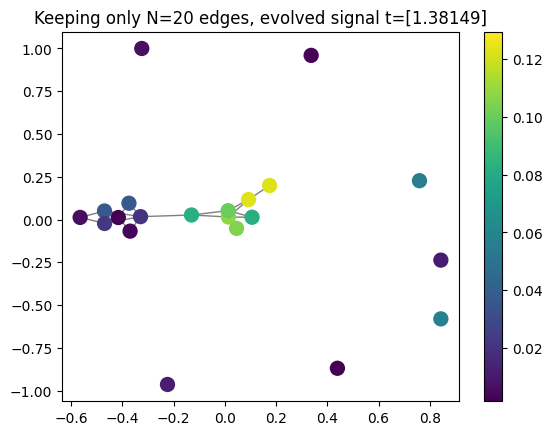

In [10]:
def filter_by_edges(L,N):
    N = 2*N
    # Assume L is your Laplacian matrix
    # Convert L to a weighted adjacency matrix W
    n_nodes = L.shape[0]
    D = np.diag(np.sum(L, axis=1))
    W = D - L

    # Sort the edges of the graph by weight
    sorted_edges = np.argsort(W.ravel())[::-1]

    # Set the weights of the first N edges to their original values, and set the rest to zero
    keep_edges = sorted_edges[:N]
    W_new = np.zeros_like(W)
    W_new.ravel()[keep_edges] = W.ravel()[keep_edges]

    # Construct a new Laplacian matrix L_new using the modified weighted adjacency matrix W
    return W_new


path_filtered = filter_by_edges(path_learned,20)
G_filtered = pg.graphs.Graph(path_filtered)
G_filtered.set_coordinates()
plotting.plot_signal(G_filtered,path_evolved)
plt.title(f"Keeping only N=20 edges, evolved signal t={tau}")
plt.savefig("images/figure 3/threshold_evolved.png")

We will try to do a simple example, let's take a delta for each node and evolve it with time

NameError: name 'G3' is not defined

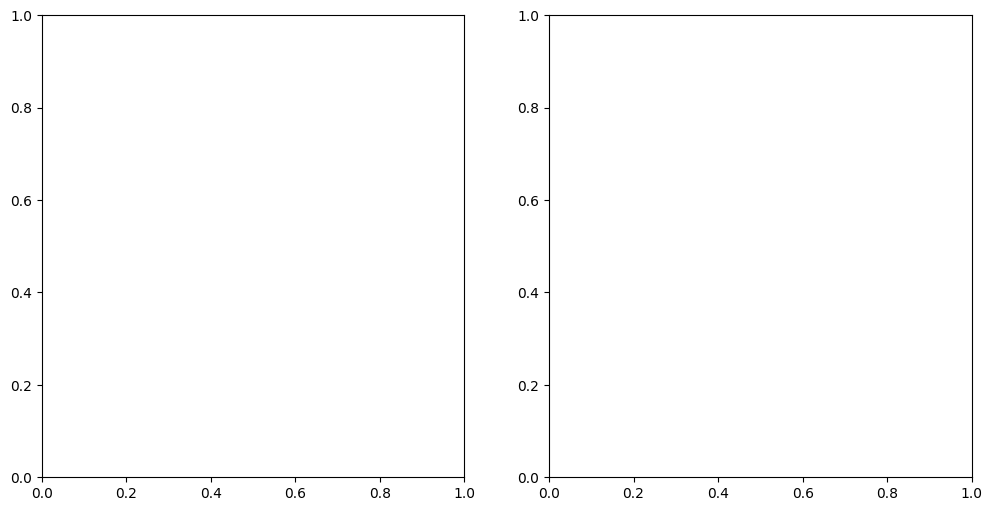

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plotting.plot_graph(G3,ax=ax[0],plot_name="Erdös Réyni (10,0.4)")
plotting.plot_graph(G4,ax=ax[1],plot_name="RBF N=10, $\kappa = 0.75$, $\sigma=0.5$")
plt.savefig("images/4graphs2.png",format="png")

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
plotting.plot_graph(G,ax=ax[0,0],plot_name="Path graph $P_5$")
plotting.plot_graph(Gring,ax=ax[0,1],plot_name="Cyclic graph $C_{20}$")
plotting.plot_graph(G3,ax=ax[1,0],plot_name="Erdös Réyni (10,0.4)")
plotting.plot_graph(G4,ax=ax[1,1],plot_name="RBF N=10, $\kappa = 0.75$, $\sigma=0.5$")
plt.savefig("images/4graphs.png",format="png")

In [ ]:
N = 5 # number of nodes for our graph
G = pg.graphs.Path(N) # create path graph with N nodes
G.set_coordinates()

Deltas are the columns here

In [ ]:
H = np.eye(N)

Take third column and plot it

In [ ]:
plotting.plot_signal(G,H[:,2])
plt.title("Signal at time t=0")

Let's evolve each signal $\tau=[1,2.5,4]$ units of time

In [ ]:
# extract the Laplacian from the line graph
L = G.L.toarray()
L = L/np.trace(L)*(L.shape[0])
# evolve the eye signal
signals = []
taus = [1,2.5,4]
for tau in taus:
    signals.append(expm(-tau*L)@H)

# plotting stuff
fig, axs = plt.subplots(1, 5, figsize=(21, 3))
for i in range(5):
    ax = axs[i]
    if i!=4:
        color = False
    else:
        color = True
    plotting.plot_signal(G,signals[1][:,i],ax=ax,colorbar=color,plot_name="delta={}, tau={}".format(i+1,2.5))
plt.savefig('images/evolved_deltas.png',format='png')

Trying to learn from the diffused signal

In [ ]:
import learnHeat as lh
# concatenate created signals
X = np.concatenate([signal for signal in signals], axis=1)
# create random graph and Laplacian
M = X.shape[1]

_, L0, H0, tau0 = lh.create_signal(N=N,tau_ground=[1,2,3],M=M,se=0.1)

In [ ]:
import array_to_latex

In [ ]:
array_to_latex.to_ltx(X)

In [ ]:
L0

In [ ]:
X.shape[:],L.shape[:],H.shape[:],len(taus) # H shape is wrong

In [ ]:
result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.0)

In [ ]:
result["L"]

In [ ]:
Lres = result["L"]
Lres[abs(Lres)<0.01] = 0
Adj = -np.copy(result["L"])
np.fill_diagonal(Adj, 0)
G_learned = pg.graphs.Graph(Adj)
G_learned.set_coordinates()
plotting.plot_graph(G_learned)

Now for the same graph, can we do the same technique with noise?

In [ ]:
se = 0.1 # standard deviation
noisyX = X + se*np.random.randn(X.shape[0],X.shape[1])
noisy_result = lh.learn_heat(X = X, 
                    L0=L, H0 = np.random.rand(15,15), tau0=[1,2,3], 
                    verbose=False, 
                    max_iter = 50, alpha = 0.1, beta=0.01)

In [ ]:
# do the same
noisy_Lres = result["L"]
noisy_Lres[abs(Lres)<0.01] = 0
noisy_Adj = -np.copy(result["L"])
np.fill_diagonal(noisy_Adj, 0)
noisy_G_learned = pg.graphs.Graph(noisy_Adj)
noisy_G_learned.set_coordinates()
plotting.plot_graph(noisy_G_learned)

Can we do the same with an arbitrary graph?

Let's create a random bigger graph with $N=20$ as in the paper.

In [ ]:
from importlib import reload
lh = reload(lh)
big_N = 20
big_graph = nx.gnp_random_graph(big_N,p=0.4)
big_L = nx.laplacian_matrix(big_graph).toarray()
# we should normalize
big_L = big_L/np.trace(big_L)*big_N
big_tau = [0.5,1,1.5,2,3]
big_X = lh.create_deltas(big_L,big_tau,se=0)

Let's create false L, H, $\tau$ to feed the algorithm together with the noisy signal

In [ ]:
big_M = big_X.shape[1]
_, not_L, not_H, not_tau = lh.create_signal(N=big_N,M=big_M,tau_ground=big_tau)

In [ ]:
big_res = lh.learn_heat(X=big_X,L0=not_L,H0=not_H,tau0=not_tau,alpha=0.05,beta=0.05,max_iter=50)

In [ ]:
big_L_learned = big_res["L"]
# create adjacency
big_W = -big_L_learned
np.fill_diagonal(big_W,0)
# cap with some threshold
big_W[abs(big_W)<0.01]=0

In [ ]:
big_tp = np.sum((big_W>0)&(big_L<0))
big_fp = np.sum((big_W>0)&(big_L>=0))
big_fn = np.sum((big_W<=0)&(big_L<0))

In [ ]:
precision = big_tp/(big_tp+big_fp)

In [ ]:
recall = big_tp/(big_tp+big_fn)

In [ ]:
f_measure = 2/(1/precision + 1/recall)
f_measure
# we obtain 0.75 it is ok

Finally, we will try to learn a ring!!!

In [ ]:
Nring = 20
Gring = pg.graphs.Ring(Nring,1)
Gring.set_coordinates()
plotting.plot_graph(Gring)

In [ ]:
Lring = Gring.L.todense()
Lring = Lring/np.trace(Lring)*Lring.shape[0]
tauring = [0.5,1,1.5,5]
Xring = lh.create_deltas(Lring,tauring)

_, notLring, Hring, tauring = lh.create_signal(N=Lring.shape[0],M=Xring.shape[1],tau_ground=tauring)

In [ ]:
resring = lh.learn_heat(X=Xring,L0=notLring,H0=Hring,tau0=[1,1,1,2],alpha=0.05,beta=0.05,max_iter=50)

In [ ]:
learned_ring = -resring["L"]
np.fill_diagonal(learned_ring,0)
# do a film on threshold
learned_ring[learned_ring < 0.17] = 0
Glearnedring = pg.graphs.Graph(learned_ring)
Glearnedring.set_coordinates()
plotting.plot_graph(Glearnedring)

In [ ]:
threshold = np.linspace(0,0.25,10)
fig1, ax1 = plt.subplots(1,5,figsize=(26,7))
for i in range(5,10):
    learned_ring = -resring["L"]
    np.fill_diagonal(learned_ring,0)
    # do a film on threshold
    learned_ring[learned_ring < threshold[i]] = 0
    Glearnedring = pg.graphs.Graph(learned_ring)
    Glearnedring.set_coordinates()
    plotting.plot_graph(Glearnedring,ax=ax1[i-5],plot_name="Threshold {}".format(np.round(threshold[i],2)))
plt.savefig("images/threshold2.png")

Final simple examples
### Trying to learn an Erdos Renyi graph

In [ ]:
G = nx.erdos_renyi_graph(10,0.4)
tau_ground = [0.5,1,2.5,4]
nx.draw(G)
L = nx.laplacian_matrix(G).toarray()
W = nx.adjacency_matrix(G).toarray()
G3 = pg.graphs.Graph(W)
G3.set_coordinates()
plotting.plot_graph(G3)

In [ ]:
X = lh.create_deltas(L,tau_ground)

In [ ]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)

In [ ]:
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned2=pg.graphs.Graph(W)
G_learned2.set_coordinates()
plotting.plot_graph(G_learned2)

In [ ]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)

Doing the same with an RBF graph

In [ ]:
_, L, _, _ = lh.create_signal2(N=10,se=0)
W4 = -L
np.fill_diagonal(W4,0)
G4 = pg.graphs.Graph(W4)
G4.set_coordinates()
plotting.plot_graph(G4)

In [ ]:
X = lh.create_deltas(L,tau_ground)

In [ ]:
res = lh.learn_heat(X=X,tau0=[1,2,3,4],alpha=0.05,beta=0.02,max_iter=75)
W = -res["L"]
np.fill_diagonal(W,0)
W[W<0.1] = 0
G_learned3=pg.graphs.Graph(W)
G_learned3.set_coordinates()
plotting.plot_graph(G_learned3)

In [ ]:
precision, recall = lh.heat_scores(res["L"],L)
plt.scatter(precision,recall)

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
plotting.plot_graph(G_learned,ax=ax[0,0],plot_name="Learned $P_5$")
plotting.plot_graph(Glearnedring,ax=ax[0,1],plot_name="Learned $C_{20}$")
plotting.plot_graph(G_learned2,ax=ax[1,0],plot_name="Learned Erdös Réyni")
plotting.plot_graph(G_learned3,ax=ax[1,1],plot_name="Learned RBF")
plt.savefig("images/4learnedgraphs.png",format="png")


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plotting.plot_graph(G_learned2,ax=ax[0],plot_name="Learned Erdös Réyni")
plotting.plot_graph(G_learned3,ax=ax[1],plot_name="Learned RBF")
plt.savefig("images/4learnedgraphs2.png",format="png")
